# YUSUF_YENIGUN_22040301052_AVENGERS_FINAL

Bu notebook, ekip içinde belirli bir parçayı sahiplenmek için hazırlanmıştır. Hücreleri sırayla çalıştırın (Run All).

In [20]:
import sys, os, platform
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Platform:", platform.platform())


Python: 3.9.6 (default, Oct 17 2025, 17:15:53) 
[Clang 17.0.0 (clang-1700.4.4.1)]
Executable: /Users/brs.ysn/Desktop/Veri Madenciliği-Final/.venv/bin/python
Platform: macOS-15.6-arm64-arm-64bit


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
)

RANDOM_STATE = 42
USE_SUBSET = True
SUBSET_N = 150_000  # 80k-200k arası makul

# Veri seti yolu
DATA_PATH = "consumer_complaints.csv"  # örn: "./data/complaints.csv"
TARGET_COL = "consumer_disputed?"  # veri setinizdeki hedef kolon adı


In [22]:
df = pd.read_csv(DATA_PATH)
print("df shape:", df.shape)
print(df.head(3))


df shape: (555957, 18)
  date_received           product     sub_product  \
0    08/30/2013          Mortgage  Other mortgage   
1    08/30/2013          Mortgage  Other mortgage   
2    08/30/2013  Credit reporting             NaN   

                                      issue       sub_issue  \
0  Loan modification,collection,foreclosure             NaN   
1  Loan servicing, payments, escrow account             NaN   
2    Incorrect information on credit report  Account status   

  consumer_complaint_narrative company_public_response                company  \
0                          NaN                     NaN           U.S. Bancorp   
1                          NaN                     NaN  Wells Fargo & Company   
2                          NaN                     NaN  Wells Fargo & Company   

  state zipcode tags consumer_consent_provided submitted_via  \
0    CA   95993  NaN                       NaN      Referral   
1    CA   91104  NaN                       NaN      Referr

/var/folders/5r/1nlqqb5n7h7ffc06kqd_9t580000gn/T/ipykernel_38326/1945908420.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


In [23]:
# Hedef kolon: Yes/No -> 1/0
df = df.dropna(subset=[TARGET_COL]).copy()
df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip()


map_y = {"Yes": 1, "No": 0, "Y": 1, "N": 0, "1": 1, "0": 0}
df["y"] = df[TARGET_COL].map(map_y)


df = df.dropna(subset=["y"]).copy()
df["y"] = df["y"].astype(int)

print("y dağılımı:\n", df["y"].value_counts())
print("positive ratio:", df["y"].mean())


y dağılımı:
 y
0    443823
1    112134
Name: count, dtype: int64
positive ratio: 0.20169545486431503


In [25]:
# Örnek: complaint narrative metni
TEXT_COL_CANDIDATES = ["consumer_complaint_narrative", "consumer complaint narrative", "complaint_what_happened"]
text_col = next((c for c in TEXT_COL_CANDIDATES if c in df.columns), None)

if text_col is None:
    print("Uyarı: Metin kolonu bulunamadı. Metin uzunluğu feature'ları atlanacak.")
    df["complaint_length_chars"] = 0
    df["complaint_length_words"] = 0
else:
    s = df[text_col].fillna("").astype(str)
    df["complaint_length_chars"] = s.str.len()
    df["complaint_length_words"] = s.str.split().str.len()

# Basit kategorik kolon adayları
CAT_CANDS = ["product", "sub_product", "issue", "sub_issue", "company", "state"]
categorical_cols = [c for c in CAT_CANDS if c in df.columns]

numeric_cols = ["complaint_length_chars", "complaint_length_words"]

features = categorical_cols + numeric_cols
print("Kullanılan feature sayısı:", len(features))
print("Kategorik:", categorical_cols)
print("Numerik:", numeric_cols)


Kullanılan feature sayısı: 8
Kategorik: ['product', 'sub_product', 'issue', 'sub_issue', 'company', 'state']
Numerik: ['complaint_length_chars', 'complaint_length_words']


In [26]:
if USE_SUBSET and len(df) > SUBSET_N:
    # sınıf oranını koruyarak örnekleme
    df0 = df[df["y"] == 0].sample(n=int(SUBSET_N * (df["y"].value_counts(normalize=True)[0])), random_state=RANDOM_STATE)
    df1 = df[df["y"] == 1].sample(n=int(SUBSET_N * (df["y"].value_counts(normalize=True)[1])), random_state=RANDOM_STATE)
    df = pd.concat([df0, df1], axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("Subset sonrası:", df.shape)
print(df["y"].value_counts(), "\npositive ratio:", df["y"].mean())


Subset sonrası: (149999, 21)
y
0    119745
1     30254
Name: count, dtype: int64 
positive ratio: 0.20169467796451976


In [27]:
X = df[features].copy()
y = df["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train pos ratio:", y_train.mean(), "Test pos ratio:", y_test.mean())


Train: (119999, 8) Test: (30000, 8)
Train pos ratio: 0.20169334744456205 Test pos ratio: 0.2017


In [28]:
numeric_features = [c for c in numeric_cols if c in X_train.columns]
categorical_features = [c for c in categorical_cols if c in X_train.columns]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("numeric_features:", numeric_features)
print("categorical_features:", categorical_features)


numeric_features: ['complaint_length_chars', 'complaint_length_words']
categorical_features: ['product', 'sub_product', 'issue', 'sub_issue', 'company', 'state']


In [29]:
def plot_roc(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()



/Users/brs.ysn/Desktop/Veri Madenciliği-Final/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/brs.ysn/Desktop/Veri Madenciliği-Final/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/brs.ysn/Desktop/Veri Madenciliği-Final/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Baseline ROC-AUC: 0.5938900012965496


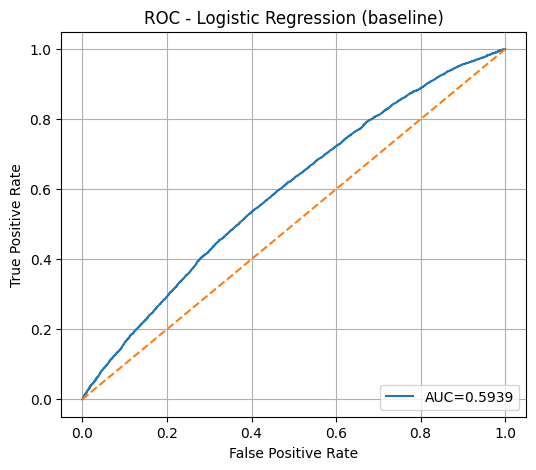

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as SkPipeline

clf_lr = SkPipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])

clf_lr.fit(X_train, y_train)
y_prob = clf_lr.predict_proba(X_test)[:, 1]
y_true = y_test.values

print("Baseline ROC-AUC:", roc_auc_score(y_true, y_prob))
plot_roc(y_true, y_prob, "ROC - Logistic Regression (baseline)")


In [32]:
X_train_vec = preprocessor.fit_transform(X_train)
X_test_vec  = preprocessor.transform(X_test)

if hasattr(X_train_vec, "toarray"):
    X_train_vec = X_train_vec.toarray()
    X_test_vec  = X_test_vec.toarray()

X_train_vec = X_train_vec.astype(np.float32)
X_test_vec  = X_test_vec.astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

print("X_train_vec:", X_train_vec.shape, "X_test_vec:", X_test_vec.shape)


X_train_vec: (119999, 2692) X_test_vec: (30000, 2692)


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 512
train_ds = TabularDataset(X_train_vec, y_train_np)
test_ds  = TabularDataset(X_test_vec,  y_test_np)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


Epoch 1 | loss=1.1001 | AUC=0.5909
Epoch 2 | loss=1.0792 | AUC=0.5929
Epoch 3 | loss=1.0684 | AUC=0.5886
Epoch 4 | loss=1.0610 | AUC=0.5942
Epoch 5 | loss=1.0533 | AUC=0.5885


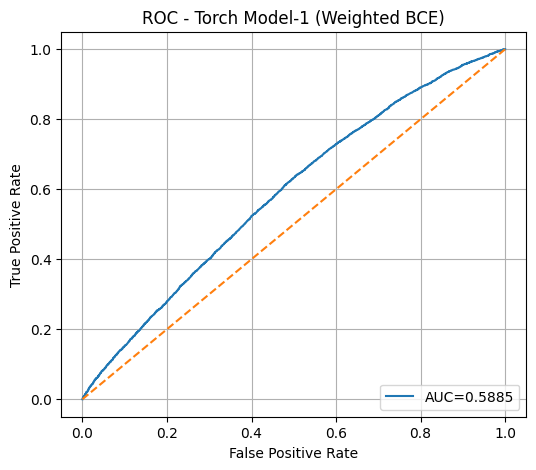

Model-1 ROC-AUC: 0.588491337625203


In [34]:
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    def forward(self, x):
        return self.net(x)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    probs, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        p = torch.sigmoid(logits).cpu().numpy().ravel()
        probs.append(p)
        ys.append(yb.numpy().ravel())
    return np.concatenate(ys), np.concatenate(probs)

pos = float((y_train_np == 1).sum())
neg = float((y_train_np == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1.0)], device=device)

input_dim = X_train_vec.shape[1]
model1 = MLP(input_dim=input_dim, hidden_dim=256, dropout=0.3).to(device)

criterion1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(model1, train_loader, criterion1, optimizer1)
    y_true1, y_prob1 = predict_probs(model1, test_loader)
    print(f"Epoch {epoch} | loss={loss:.4f} | AUC={roc_auc_score(y_true1, y_prob1):.4f}")

plot_roc(y_true1, y_prob1, "ROC - Torch Model-1 (Weighted BCE)")
print("Model-1 ROC-AUC:", roc_auc_score(y_true1, y_prob1))


[Model-2] Epoch 1 | loss=0.0584 | AUC=0.5835
[Model-2] Epoch 2 | loss=0.0505 | AUC=0.5893
[Model-2] Epoch 3 | loss=0.0491 | AUC=0.5914
[Model-2] Epoch 4 | loss=0.0486 | AUC=0.5954
[Model-2] Epoch 5 | loss=0.0483 | AUC=0.5912


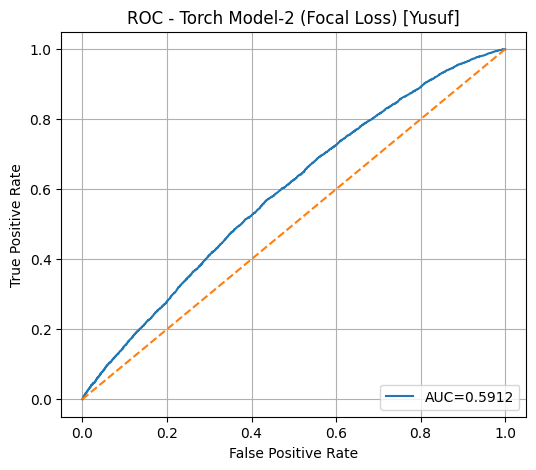

Model-2 ROC-AUC: 0.591192841417771


In [35]:
import torch.nn as nn
import torch.optim as optim

class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    def forward(self, x):
        return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        prob = torch.sigmoid(logits)
        ce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p_t = prob * targets + (1 - prob) * (1 - targets)
        loss = ce * ((1 - p_t) ** self.gamma)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        return (alpha_t * loss).mean()

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    probs, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        p = torch.sigmoid(logits).cpu().numpy().ravel()
        probs.append(p)
        ys.append(yb.numpy().ravel())
    return np.concatenate(ys), np.concatenate(probs)

input_dim = X_train_vec.shape[1]
model2 = MLP2(input_dim=input_dim, hidden_dim=512, dropout=0.5).to(device)
criterion2 = FocalLoss(alpha=0.25, gamma=2.0)
optimizer2 = optim.Adam(model2.parameters(), lr=5e-4, weight_decay=1e-4)

EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(model2, train_loader, criterion2, optimizer2)
    y_true2, y_prob2 = predict_probs(model2, test_loader)
    print(f"[Model-2] Epoch {epoch} | loss={loss:.4f} | AUC={roc_auc_score(y_true2, y_prob2):.4f}")

plot_roc(y_true2, y_prob2, "ROC - Torch Model-2 (Focal Loss) [Yusuf]")
print("Model-2 ROC-AUC:", roc_auc_score(y_true2, y_prob2))


In [36]:
print("YUSUF: Baseline LR + Torch Model-1 (Weighted BCE) + ROC üretimi tamamlandı.")


YUSUF: Baseline LR + Torch Model-1 (Weighted BCE) + ROC üretimi tamamlandı.
